# Using pre-trained CNNs 
Our first attempt for the multiclass problem of classifying the patterns given was to perform transfer learning onto the images.

In [112]:
image_reshape_size = 150
minimum_number_pixels = (1000 , 30000)
maximum_percentage_black_pixels = 0.5

In [113]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import multiprocessing as mp
from sklearn.cluster import KMeans
# example of tending the vgg16 model
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import *
from keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

Since we don't have still the names for each pattern, we'll use the Patterns numbers as its class for training, use the HEP annot's images as the test set for the problem and check to see if the results are in accordance.

Here we see the results of the image treatment that regularized the data's shapes for classification

In [114]:
# import library
from google.colab import drive

#mount the drive
drive.mount('/content/drive')
# go to the url and get the password for the drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [141]:
def size_hist(hist, n_classes, y_pattern_dict):
  plt.subplots(7, 2, figsize=(15, 10))
  for i in range(n_classes):
    plt.subplot(7, 2, i+1)
    plt.title(f'Pattern {int(y_pattern_dict[i])}')
    plt.hist(hist[i], 'auto')
  plt.tight_layout()
  plt.show()

def transform_square(X):
  #Images are currently cropped around the cell, this function makes all cells have a black square around them with the same
  #size with the size of their largest dimension
  Xcopy = X.copy()
  for i in range(len(X)):
    if X[i].shape[0] != X[i].shape[1]:
      max_dimension = max(X[i].shape[0],X[i].shape[1])
      aux = np.zeros((max_dimension, max_dimension))
      if max_dimension == X[i].shape[0]:
        margin = int((max_dimension - X[i].shape[1])/2)
        aux[:, margin: X[i].shape[1]+margin] = X[i]
      else:
        margin = int((max_dimension - X[i].shape[0])/2)
        aux[margin: X[i].shape[0]+margin, :] = X[i]
      Xcopy[i] = aux
  return Xcopy

def standardize_classes(X, y):
  Xcopy = X.copy()
  for i in range(len(y[0])): #iterating between 14 classes
    arr = np.where(y[:, i]==1)[0]
    max_dimension = 0
    for cell in X[arr]: #find the largest dimension in a given class
      max_dimension = max(cell.shape[0], max_dimension)
    for j in arr:
      aux = np.zeros((max_dimension, max_dimension))
      margin = int((max_dimension - X[j].shape[0])/2)
      aux[margin: margin + X[j].shape[0], margin: margin + X[j].shape[0]] = X[j]
      Xcopy[j] = aux
  return Xcopy


def resize_square(X, y, cnn_input_size, upscaling=False, full_size=True):
  # The resizing implemented is:
    # For smaller cells: no upscaling, just placing a smaller cell in a bigger black square if upscaling is false
      #If upscaling is true, then it upscales
    # for bigger cells: downscaling
  if full_size:
    Xcopy = np.zeros((len(X), cnn_input_size, cnn_input_size))
    for i in range(len(X)):
      aux = cv2.resize(X[i], dsize=(cnn_input_size, cnn_input_size), interpolation=cv2.INTER_CUBIC)
      Xcopy[i] = np.asarray(aux, 'float32')
    return Xcopy
  if upscaling==True:
    X = standardize_classes(X, y)
  Xcopy = np.zeros((len(X), cnn_input_size, cnn_input_size))
  for i in range(len(X)):
    if X[i].shape[0] < cnn_input_size and upscaling==False:
      aux = np.zeros((cnn_input_size, cnn_input_size))
      margin = int((cnn_input_size - X[i].shape[0])/2)
      aux[margin: margin + X[i].shape[0], margin: margin + X[i].shape[0]] = X[i]
    elif X[i].shape[0] >= cnn_input_size or upscaling==True:
      aux = cv2.resize(X[i], dsize=(cnn_input_size, cnn_input_size), interpolation=cv2.INTER_CUBIC)
    Xcopy[i] = np.asarray(aux, 'float16')
  return Xcopy

def grayscale_2_3channel(X):
  #copies grayscale into other channels for VGG
  return np.repeat(np.expand_dims(X, 3), 3, axis=3)
  
def kmeans_2_3channel(X):
  #copies kmeans segmentation into other channels for VGG
  out = np.repeat(np.expand_dims(X, 3), 3, axis=3)
  for i in range(len(X)):
    k, m = run_kmeans(X[i])
    out[i][:,:,1] = k
    out[i][:,:,2] = m
  return out

def filter_db(X, y, pixel_count, percentage):
  # returns X and y inside parameters of
  # pixel_count and percentage of empty space
  Xl = []
  yl = []
  for i in range(len(X)):
    iclass = np.argmax(y[i])
    size = X[i].shape[0]*X[i].shape[1]
    percent = (100*np.count_nonzero(X[i]==0))/size
    if size < pixel_count[iclass][0] and size > pixel_count[iclass][1]:
      if percent < percentage[iclass][0] and percent > percentage[iclass][1]:
        Xl.append(X[i])
        yl.append(y[i])
  return Xl,np.asarray(yl)

def data_augmentation(X, y):
  # data augmentation using fliping and rotation
  x_out = np.copy(X)
  y_out = np.copy(y)
  flips = np.asarray([np.flipud(img) for img in X])
  x_out = np.concatenate((x_out, flips))
  y_out = np.concatenate((y_out, y))
  flips = np.asarray([np.fliplr(img) for img in X])
  x_out = np.concatenate((x_out, flips))
  y_out = np.concatenate((y_out, y))
  flips = np.asarray([np.flip(img, (0, 1)) for img in X])
  x_out = np.concatenate((x_out, flips))
  y_out = np.concatenate((y_out, y))
  return x_out, y_out

def normalize(X):
    for idx, img in enumerate(X):
        ar = np.array(img).astype(np.float32)
        mn = np.min(ar)
        mx = np.max(ar)
        X[idx] = (ar - mn) * (1.0 / (mx - mn))
    return X

Import images

In [149]:
pattern_folder = "/content/drive/MyDrive/Images/Cells/CytoCells_pattern"

# y_pattern_dict is a vector that translates the position of the one-hot-encoder array to the pattern number observed in the folders
        # Example:
        # if 25 is at position 0, it means that an image with an output of [1 0 0...] is classified as being from pattern 25
def get_patterns(pattern_folder, green=False):
  print('Importing...')
  n_classes = len(glob.glob(pattern_folder + '/*'))
  y_pattern_dict = np.zeros(n_classes)

  X = np.array([]) #dataset
  y = []

  hist_pixel_count = [[] for i in range(n_classes)] #matrix with cell pixel count per pattern
  hist_percentage_cyto = [[] for i in range(n_classes)]#matrix with cell max dimension per pattern
  i = 0
  for pattern_number_path in glob.glob(pattern_folder + '/*'): #iterating in every pattern
    pattern_number = int(pattern_number_path[len(pattern_folder)+5:]) #Number of pattern
    y_pattern_dict[i] = pattern_number 
    for np_cells in glob.glob(pattern_number_path + '/*'):#iterating for every numpy array
      if (green == True and np_cells[-5]=='G') or (green == False and np_cells[-5]!='G'):
        print(f'{np_cells[len(pattern_number_path)+1:]}') 
        a = np.load(np_cells, allow_pickle=True) #gets array from drive
        # One hot encoder
        auxy = np.zeros(n_classes)
        auxy[i] = 1
        for j in range(len(a)):
          y.append(auxy)
  
        X = np.append(X, a)
        #histogram construction
        for img in a:
          size = img.shape[0]*img.shape[1]
          hist_pixel_count[i].append(size)
          hist_percentage_cyto[i].append(100*np.count_nonzero(img[:,:,2]==0)/size)
    i += 1
  y = np.array(y)

  #Dumb way to delete channels, probably glitchy and wrong, just doing it for speed rn
  if green == True:
    for i in range(len(X)):
      X[i] = (X[i][:, :, 0]).copy()

  return X, y, n_classes, y_pattern_dict, hist_pixel_count, hist_percentage_cyto

def get_parameters(hist, n_classes, y_pattern_dict, percent=False):
  # gets parameters for filtering
  critical_out = []
  for i in range(n_classes):
    critical1 = np.quantile(hist[i], 0.9)
    if percent:
      critical2 = np.quantile(hist[i], 0.1)
    else:
      critical2 = np.quantile(hist[i], 0.1)
    critical_out.append((int(critical1), int(critical2)))
  return critical_out


In [117]:
X, y, n_classes, y_pattern_dict, hist_pixel_count, hist_percentage = get_patterns(pattern_folder, True)

Importing...
pat_10_1G.npy
pat_10_2G.npy
pat_10_3G.npy
pat_10_4G.npy
pat_11_1G.npy
pat_11_2G.npy
pat_11_3G.npy
pat_11_4G.npy
pat_12_1G.npy
pat_12_2G.npy
pat_12_3G.npy
pat_12_4G.npy
pat_13_1G.npy
pat_13_2G.npy
pat_13_3G.npy
pat_13_4G.npy
pat_15_1G.npy
pat_15_2G.npy
pat_15_3G.npy
pat_15_4G.npy
pat_16_1G.npy
pat_16_2G.npy
pat_16_3G.npy
pat_16_4G.npy
pat_18_1G.npy
pat_18_2G.npy
pat_18_3G.npy
pat_18_4G.npy
pat_19_1G.npy
pat_19_2G.npy
pat_19_3G.npy
pat_19_4G.npy
pat_19_5G.npy
pat_22_1G.npy
pat_22_2G.npy
pat_22_3G.npy
pat_22_4G.npy
pat_23_1G.npy
pat_23_2G.npy
pat_23_3G.npy
pat_23_4G.npy
pat_25_1G.npy
pat_25_2G.npy
pat_25_3G.npy
pat_25_4G.npy
pat_7_1G.npy
pat_7_2G.npy
pat_7_3G.npy
pat_7_4G.npy
pat_8_1G.npy
pat_8_2G.npy
pat_8_3G.npy
pat_8_4G.npy
pat_8_5G.npy
pat_9_1G.npy
pat_9_2G.npy
pat_9_3G.npy
pat_9_4G.npy


In [150]:
# filter bad cells, augment data, square data
print("Filtering")
pixel_parameters = get_parameters(hist_pixel_count, n_classes, y_pattern_dict)
percentage_parameters = get_parameters(hist_percentage, n_classes, y_pattern_dict, True)
X_filtered, y_filtered = filter_db(X, y, pixel_parameters, percentage_parameters)
print('Normalizing images')
imgs_normalized = normalize(X_filtered)
print("Making cells square")
square = transform_square(imgs_normalized)
print("Resizing to the correct size for classification")
res_square = resize_square(square, y_filtered, image_reshape_size)

Filtering
Normalizing images
Making cells square
Resizing to the correct size for classification


In [151]:
print(f'the number of images with these restrictions is: {len(y_filtered)}')

the number of images with these restrictions is: 1704


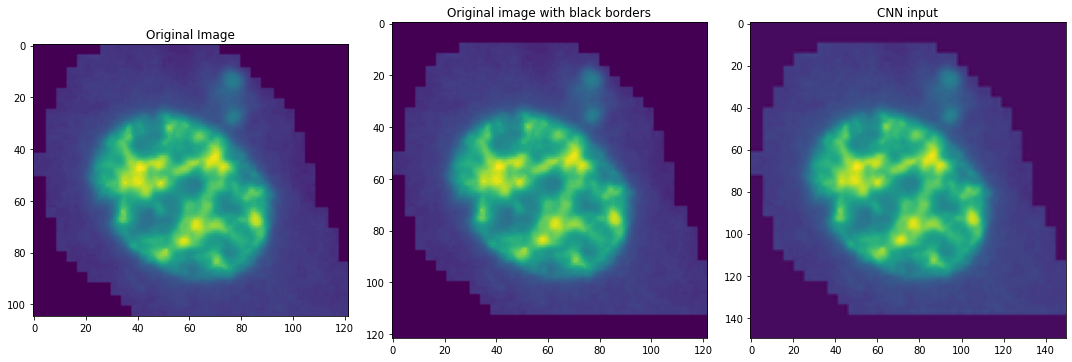

In [152]:
img = 10
plt.subplots(1, 3, figsize=(15, 15))

plt.subplot(131)
plt.title('Original Image')
plt.imshow(X_filtered[img])

plt.subplot(132)
plt.title('Original image with black borders')
plt.imshow(square[img])

plt.subplot(133)
plt.title('CNN input')
plt.imshow(res_square[img])

plt.tight_layout()
plt.show()

In [153]:
cells = grayscale_2_3channel(res_square)

In [154]:
Xtrain, Xtest, ytrain, ytest = train_test_split(cells, y_filtered, test_size=0.25, random_state=42)
Xtrain, ytrain = data_augmentation(Xtrain, ytrain)

In [155]:
np.max(Xtrain[0])

0.9894615411758423

In [156]:
# load model without classifier layers
K.clear_session()
model = VGG16(include_top=False, input_shape=(image_reshape_size, image_reshape_size, 3), weights = 'imagenet')
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
class2 = Dense(512, activation='relu')(class1)
drop = Dropout(0.5)(class2)
output = Dense(n_classes, activation='softmax')(drop)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001),metrics=["accuracy"]) 
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [157]:
n_epochs = 20
batch_size = 64
callback = EarlyStopping( monitor='val_accuracy',
                          min_delta=0,
                          patience=3,
                          verbose=0,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)
# fit
history = model.fit(Xtrain, ytrain, epochs=n_epochs, batch_size=batch_size, shuffle=True, validation_data=(Xtest, ytest), callbacks=[callback])

Epoch 1/20
80/80 [==============================] - 9s 100ms/step - loss: 2.0838 - accuracy: 0.3206 - val_loss: 1.4815 - val_accuracy: 0.5258
Epoch 2/20
80/80 [==============================] - 6s 71ms/step - loss: 1.4103 - accuracy: 0.5186 - val_loss: 1.2675 - val_accuracy: 0.5798
Epoch 3/20
80/80 [==============================] - 6s 71ms/step - loss: 1.1232 - accuracy: 0.6242 - val_loss: 1.2106 - val_accuracy: 0.5822
Epoch 4/20
80/80 [==============================] - 6s 70ms/step - loss: 0.9306 - accuracy: 0.6841 - val_loss: 1.1019 - val_accuracy: 0.6291
Epoch 5/20
80/80 [==============================] - 6s 70ms/step - loss: 0.7931 - accuracy: 0.7242 - val_loss: 1.1561 - val_accuracy: 0.6103
Epoch 6/20
80/80 [==============================] - 6s 72ms/step - loss: 0.6563 - accuracy: 0.7733 - val_loss: 1.0998 - val_accuracy: 0.6526
Epoch 7/20
80/80 [==============================] - 6s 70ms/step - loss: 0.5445 - accuracy: 0.8091 - val_loss: 1.1572 - val_accuracy: 0.6408
Epoch 8/20
8

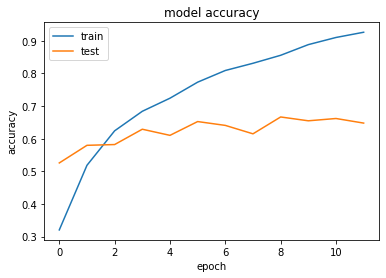

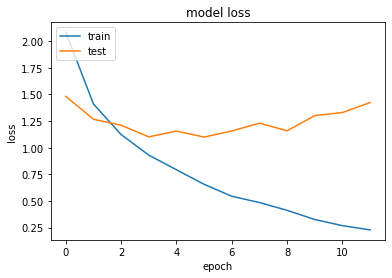

In [158]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

This shows some orverfitting, that can possibly be remedied with GANs.

# Image viewing 

In [159]:
#%% SECTION de definition et d'imports a lancer au debut
# Si vous êtes dans colab mettre colaboratory ET notebook a True
# si vous êtes en local dans un notebook mettez colbaoratory a False
#      et installez bokeh vous-même
# Si vous utilisez le script sur une machine local non pas dans un notebook 
# mettez les deux à False 
notebook=True
colaboratory=True
if notebook:
    from IPython.display import Audio
    if colaboratory:
        !pip install bokeh
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()
    from bokeh.colors import Color as bcolor
    from bokeh.colors.rgb import RGB


import numpy as np

import matplotlib.pyplot as plt
import scipy 
from scipy.signal import lfilter
import scipy.io
import platform
import time

import tempfile
import os

def RGBtoYCrCb(im,ty='8bit'): 
    assert len(im.shape)==3 and im.shape[2]==3, 'image dans un mauvais format'
    if ty=='8bit':
        delta=128 #ce delta est simplement le milieu de la plage des valeurs 
                    # possibles. 
    out=np.empty(im.shape)
    Y=0.299*im[:,:,0]+0.587*im[:,:,1]+0.114*im[:,:,2]
    Cr=(im[:,:,0]-Y)*0.713+delta
    Cb=(im[:,:,2]-Y)*0.564+delta
    return (Y,Cr,Cb)



def YCrCbtoRGB(Y,Cr,Cb,ty='8bit'):
    delta=128
    out=np.empty([*Y.shape,3],dtype=np.float32)
    out[:,:,0]=Y+1.402*(Cr-delta)
    out[:,:,1]=Y-0.34414*(Cb-128)-0.71414*(Cr-128)
    out[:,:,2]=Y+1.772*(Cb-128)
    return out
    
import skimage.transform
if notebook:
  liste_couleurs_grises=[]
  for k in range(256):
    liste_couleurs_grises.append(RGB(k,k,k))
  def affiche_pour_colab(im,normalise=True,MINI=0.0, MAXI=255.0,titre=''): #special colab, ne pas regarder
    def normalise_image_pour_bokeh(X,normalise=True,MINI=0.0, MAXI=255.0,titre=''):
      Y=(X.copy())
      if len(Y.shape)==2: 
        Y=np.zeros((*Y.shape,3))
        for k in range(3):
          Y[:,:,k]=X.copy()
   
      if normalise:
        Y-=Y.min()
        Y/=Y.max()
        Y*=255
      else:
        Y-=MINI
        Y/=(MAXI-MINI)
        Y*=255

      Y=Y.astype(np.uint8)
      sortie=np.empty(Y.shape[:2],dtype=np.uint32)
      view=sortie.view(dtype=np.uint8).reshape((Y.shape[:2]+(4,)))
      for k in range(3):
        view[:,:,k]=Y[:,:,k]
      view[:,:,3]=255
      return sortie
    img=normalise_image_pour_bokeh(np.flipud(im),normalise=normalise,MINI=MINI,MAXI=MAXI)# np.flipud(np.fliplr(im)))
    p = figure(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")],title=titre)
    p.x_range.range_padding = p.y_range.range_padding = 0

    # must give a vector of images
    p.image_rgba(image=[img],x=0,y=0, dw=im.shape[1], dh=im.shape[0])
    showbokeh(p)

  def affiche(im,normalise=True,MINI=0.0, MAXI=255.0,titre='',printname=False):
      affiche_pour_colab(im,normalise=normalise,MINI=MINI, MAXI=MAXI,titre=titre) 
         # sous google colab beaucoup d''options disparaissent

else:
    def affiche(im,normalise=True,MINI=0.0, MAXI=255.0,titre='',printname=False):
        """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS 
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee 
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI et MAXI seront mis a 0 et 255 dans l'image 
        resultat
        """
        imt=np.float32(im.copy())
        if platform.system()=='Darwin': #on est sous mac
            prephrase='open -a GIMP-2.10.app ' #certainement à adapter
            endphrase=' ' 
        else: #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais comment 
                                   #faire. Si vous savez dites-moi.)
            prephrase='gimp '
            endphrase= ' &'
    
        if normalise:
            m=imt.min()
            imt=imt-m
            M=imt.max()
            if M>0:
                imt=imt/M

        else:
            imt=(imt-MINI)/(MAXI-MINI)
            imt[imt<0]=0
            imt[imt>1]=1
    
        if titre!='':
            titre='_'+titre+'_'
        titre=titre.replace(' ','')
        nomfichier=tempfile.mktemp('TPIMA'+titre+'.png')
        commande=prephrase +nomfichier+endphrase
        skio.imsave(nomfichier,imt)
        os.system(commande)
        if printname:
            print(nomfichier)


if notebook:
    def plot(*argv):
        if len(argv)==2:
            x=argv[0]
            y=argv[1]
        elif (len(argv)==1):
            x=np.arange(0,len(y))
            y=argv[0]
        else:
            raise Exception("Erreur dans les graphiques: n'arriverait \
                pas hors de google colaboratory")
    
        p=figure()
        p.line(x,y)
        showbokeh(p)
    def stem(*argv):
        if len(argv)==2:
            x=argv[0]
            y=argv[1]
        elif len(argv)==1:
            x=np.arange(0,len(y))
            y=argv[0]
        else:
            raise Exception("Erreur dans les graphiques: \
                            n'arriverait pas hors de google colaboratory")

        p = figure()#title="simple line example", x_axis_label='x',
                    #y_axis_label='y')

        # add a line renderer with legend and line thickness
        p.segment(x,0,x, y, legend_label="Temp.", line_width=2)

        showbokeh(p)
    def show():
        return
else:
    plot=plt.plot
    stem=plt.stem
    show=plt.show # force l'affichage du graphique courant

def norm(X):
    return ((abs(X)**2).sum())**0.5
def read_image(fi):
    return np.float32(skio.imread(fi))

In [160]:
def cells_plot(X, y_pattern_dict, ctype, image_shape, collumn_size):
  n_classes = y_pattern_dict.shape[1]
  count = 0
  limit = collumn_size*(image_shape+2)
  out = np.zeros((2,limit))
  row = np.array([])
  n = 0
  for i, x in enumerate(X):
    c = np.argmax(y_pattern_dict[i])
    if c == ctype:
      if count == 0:
        row = np.c_[x, np.zeros((image_shape,2))]
      else:
        row = np.c_[row, np.c_[x, np.zeros((image_shape,2))]]
      count += 1
      if count == collumn_size:
        n += collumn_size
        out = np.r_[out, np.zeros((2,limit))]
        out = np.r_[out, row]
        row = np.array([])
        count = 0
        if n>=100:
          break
  n += count
  if count != 0:
    for i in range(count, collumn_size):
        row = np.c_[row, np.c_[np.zeros((image_shape,image_shape+2))]]
    out = np.r_[out, np.zeros((2,limit))]
    out = np.r_[out, row]
  w, h = out.shape
  output = np.zeros((w, h, 3))
  output[:,:,1] = out
  return output, n
  

In [161]:
for i in range(n_classes):
  mozaic , n = cells_plot(res_square, y_filtered, i, image_reshape_size, 10)
  affiche(mozaic,titre=f'Pattern {int(y_pattern_dict[i])}')